## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np
import torch.nn as nn

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import cv2
from skimage import metrics

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
#     plt.figure(figsize=(7, 4))
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=10)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cuda')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model.to('cuda')

def run_one_image(img, model, mask_ratio, feature_embeds=None, zeros=False, visualize=True, random=False):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    embeds, _, _ = model.forward_encoder(x.float().cuda(), mask_ratio=mask_ratio)
    embeds = embeds.detach().cpu()
    loss, y, mask = model(x.float().cuda(), mask_ratio=mask_ratio, feature_embeds=feature_embeds, zeros=zeros, random=random)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    if visualize:
        # visualize the mask
        mask = mask.detach()
        mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
        mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
        mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

        x = torch.einsum('nchw->nhwc', x)

        # masked image
        im_masked = x * (1 - mask)

        # MAE reconstruction pasted with visible patches
        im_paste = x * (1 - mask) + y * mask

        # make the plt figure larger
        plt.rcParams['figure.figsize'] = [24, 24]

        plt.subplot(1, 4, 1)
        show_image(x[0], "original")

        plt.subplot(1, 4, 2)
        show_image(im_masked[0], "masked")

        plt.subplot(1, 4, 3)
        show_image(y[0], "reconstruction")

        plt.subplot(1, 4, 4)
        show_image(im_paste[0], "reconstruction + visible")

        plt.show()
    
    return y #, embeds

### Load an image

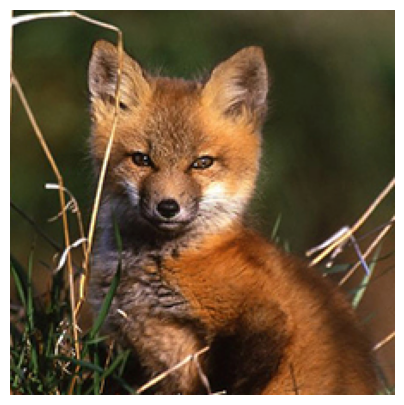

In [3]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [4]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth

chkpt_dir = 'mae_visualize_vit_base.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')


<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


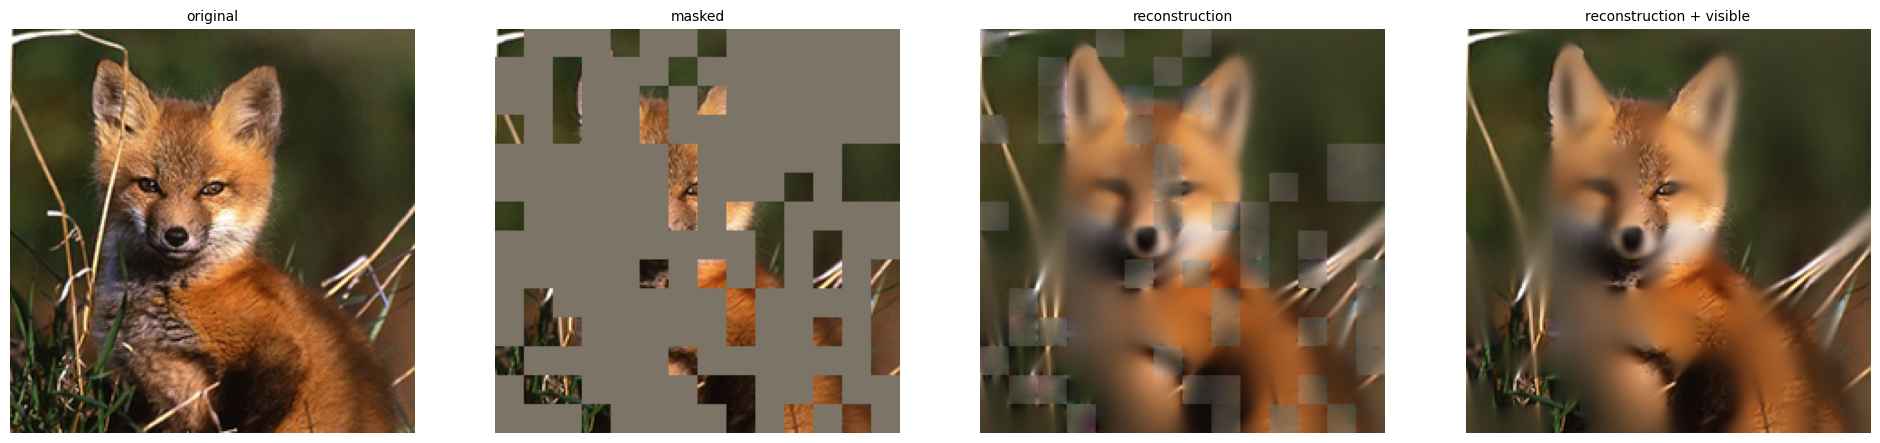

In [5]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
rec_img_1 = run_one_image(img, model_mae, mask_ratio=0.75)

MAE with pixel reconstruction:


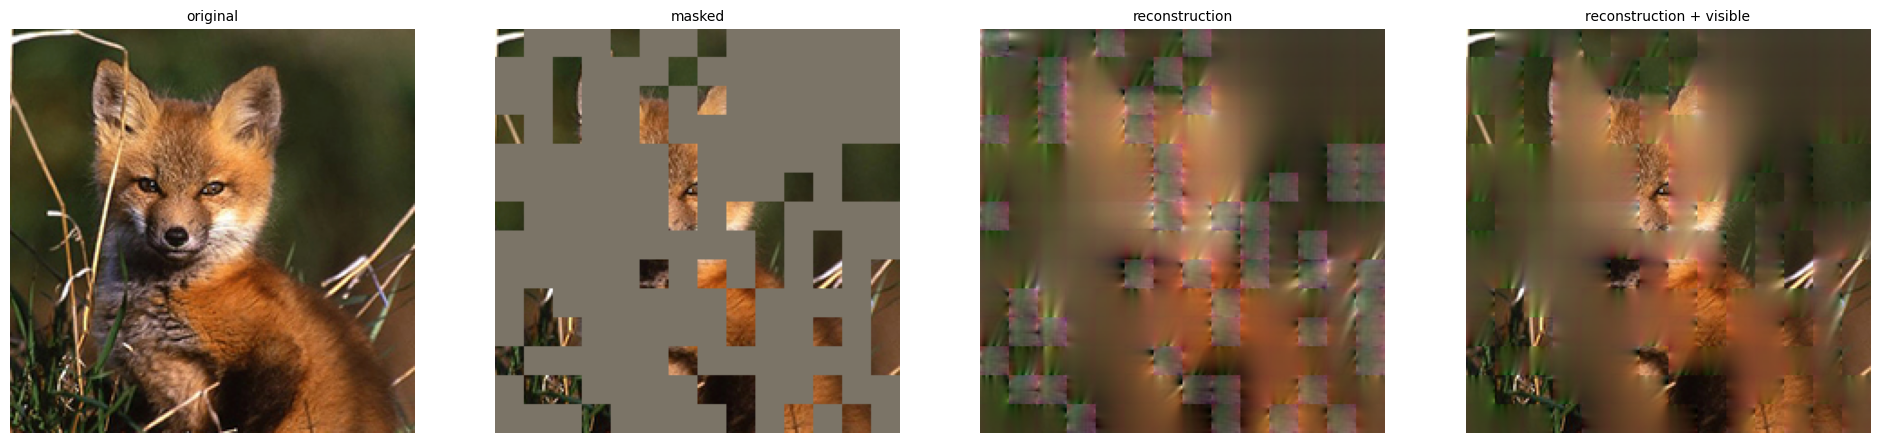

In [115]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
rec_img_1, emb = run_one_image(img, model_mae, mask_ratio=0.75, feature_embeds=[1, 200], zeros=False)

In [119]:
emb[:, :, 1].mean()

tensor(0.0189)

MAE with pixel reconstruction:


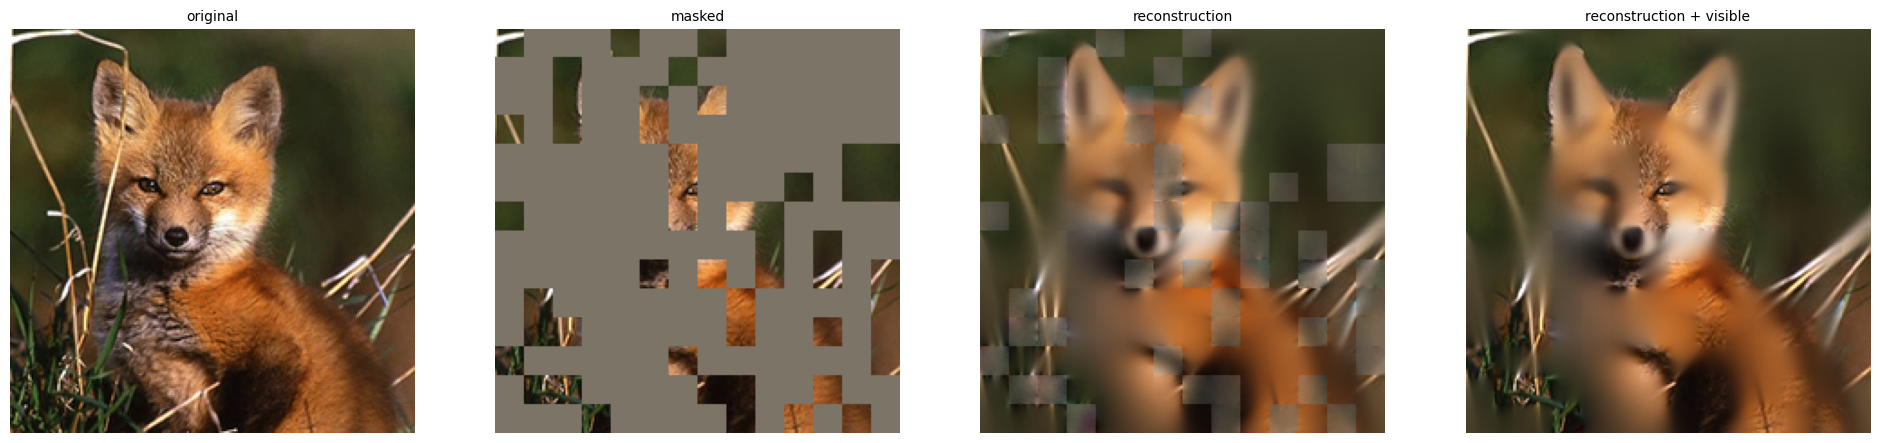

In [113]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
rec_img_1 = run_one_image(img, model_mae, mask_ratio=0.75, feature_embeds=[0, 2], zeros=True)

MAE with pixel reconstruction:


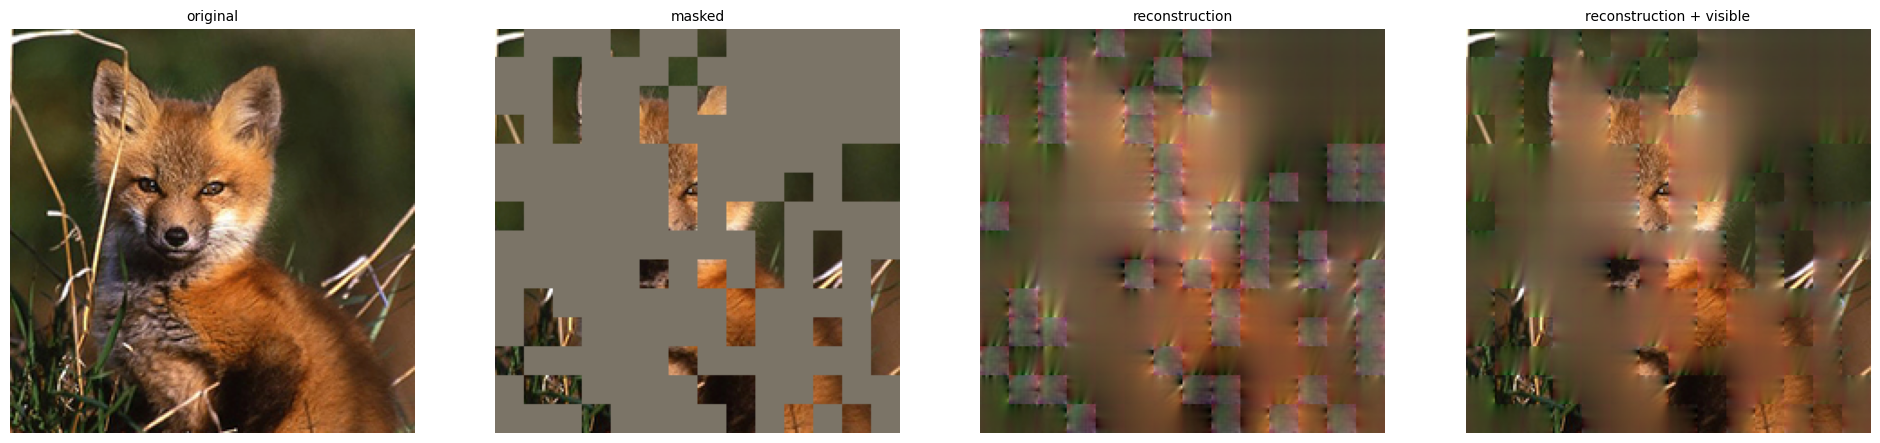

In [7]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
rec_img_1 = run_one_image(img, model_mae, mask_ratio=0.75, feature_embeds=[0, 200], zeros=False)

MAE with pixel reconstruction:


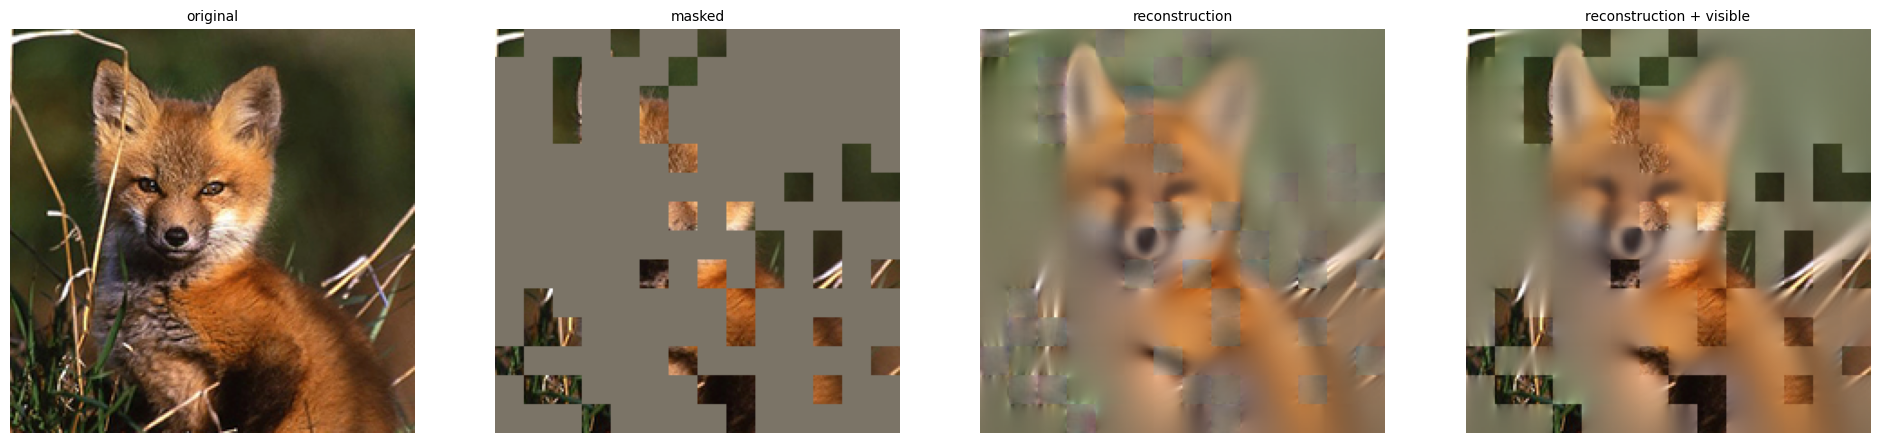

In [8]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
rec_img_2 = run_one_image(img, model_mae, mask_ratio=0.8, feature_embeds=[-200, 769], zeros=True)

MAE with pixel reconstruction:


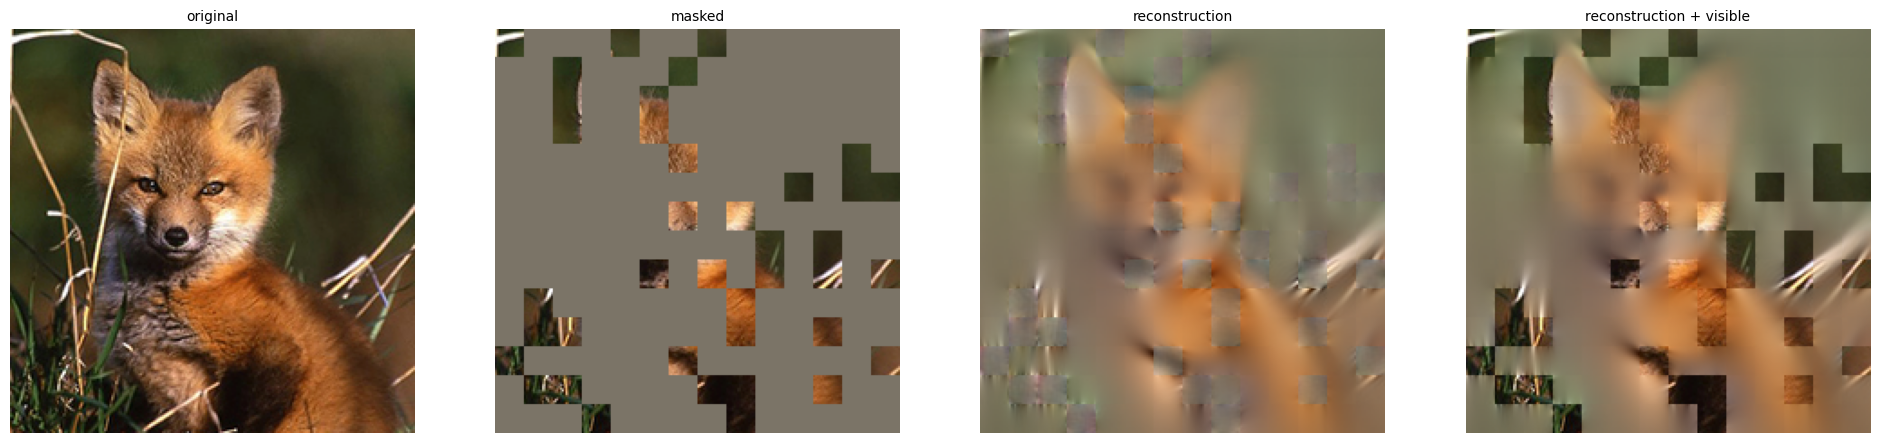

In [11]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
rec_img_2 = run_one_image(img, model_mae, mask_ratio=0.8, feature_embeds=[-200, 769], zeros=False)

MAE with pixel reconstruction:


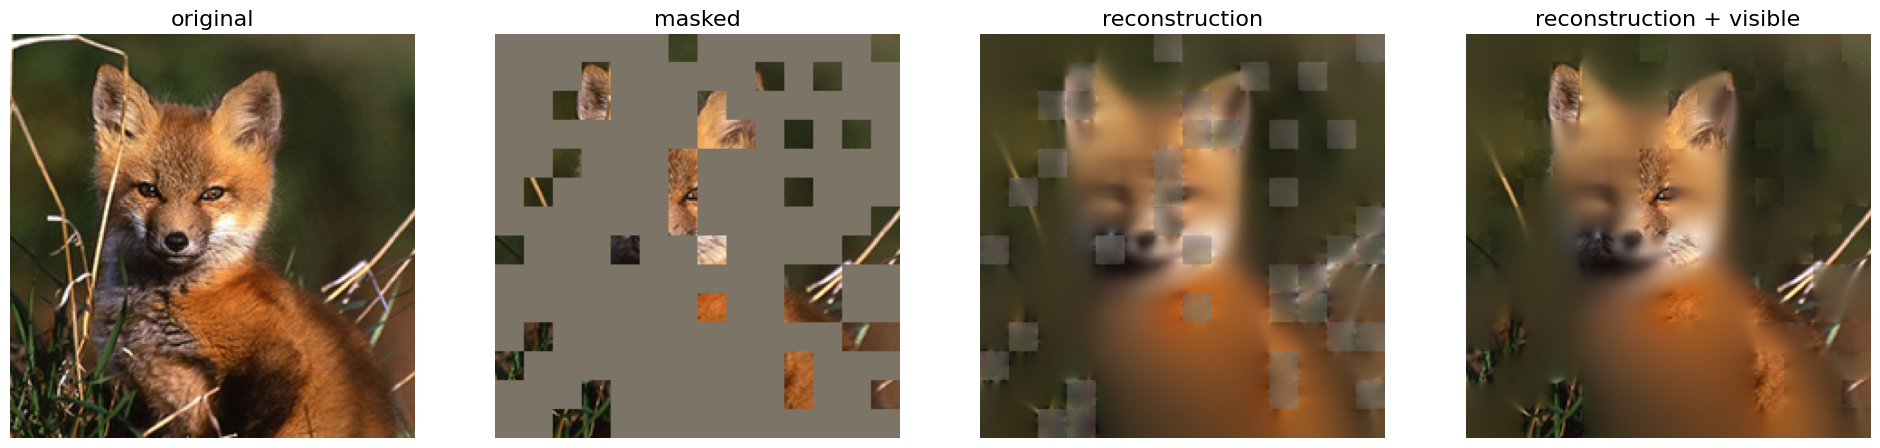

In [75]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
rec_img_2 = run_one_image(img, model_mae, 0.8, change_features=200)

In [6]:
rec_img_1.shape

torch.Size([1, 224, 224, 3])

In [7]:
rec_img_1[0].shape, img.shape

(torch.Size([224, 224, 3]), (224, 224, 3))

In [9]:
rec_img_1[0].shape, img.shape

(torch.Size([224, 224, 3]), (224, 224, 3))

In [10]:
loss = nn.MSELoss()
mse_loss_1 = loss(rec_img_1[0], torch.from_numpy(img)).item()
mse_loss_2 = loss(rec_img_2[0], torch.from_numpy(img)).item()

In [11]:
mse_loss_2, mse_loss_1

(0.3710636055287063, 0.3137603345845823)

In [5]:
annots_path = '/home/hkhachatrian/mae/annotations/cs/cs4pc_256_val.npy'
annots = np.load(annots_path, allow_pickle=True).item()

In [39]:
def get_reconstructions(mask_ratio):
    reconstracted_imgs_orig = []
    reconstracted_imgs_mean = []
    reconstracted_imgs_zeros = []
    images = []
    mse_per_image = np.zeros((30, 3))
    _metrics = np.zeros((3, 3))     # [[mse, psnr, ssim]]  # orig
                                    # [[mse, psnr, ssim]]  # mean
                                    # [[mse, psnr, ssim]]  # zeros
    k = 0
    for i in tqdm(range(len(annots['images']))): #annots['images']): len(annots['images'])
        path = annots['images'][i]['file_name']
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
        img = img / 255.
        assert img.shape == (224, 224, 3)

        # normalize by ImageNet mean and std
        img = img - imagenet_mean
        img = img / imagenet_std

        images.append(torch.from_numpy(img).unsqueeze(0).detach())
        rec_img_orig = run_one_image(img, model_mae, mask_ratio, visualize=False).cpu().detach()
        reconstracted_imgs_orig.append(rec_img_orig)
        # rec_img_mean = run_one_image(img, model_mae, mask_ratio, feature_embeds=[0, 200], visualize=False).cpu().detach()
        # reconstracted_imgs_mean.append(rec_img_mean)
        # rec_img_zeros = run_one_image(img, model_mae, mask_ratio, feature_embeds=[0, 200], zeros=True, visualize=False, random=True).cpu().detach()
        # reconstracted_imgs_zeros.append(rec_img_zeros)
        # rec_img_zeros = run_one_image(img, model_mae, mask_ratio, feature_embeds=200, zeros=True, visualize=False, random=True).cpu().detach()
        # reconstracted_imgs_zeros.append(rec_img_zeros)
        rec_img_zeros = run_one_image(img, model_mae, mask_ratio, feature_embeds=[568, 769], zeros=True, visualize=False).cpu().detach()
        reconstracted_imgs_zeros.append(rec_img_zeros)
        
        j = i + 1
        if j % 32 == 0:
#             print(i)
            tmp_gt = torch.cat(images[j-32:j], dim=0).detach().numpy()
            tmp = torch.cat(reconstracted_imgs_orig[j-32:j], dim=0).detach().numpy()
            mse_per_image[k][0] = metrics.mean_squared_error(tmp_gt, tmp)
            
            # tmp = torch.cat(reconstracted_imgs_mean[j-32:j], dim=0).detach().numpy()
            # mse_per_image[k][1] = metrics.mean_squared_error(tmp_gt, tmp)
            
            tmp = torch.cat(reconstracted_imgs_zeros[j-32:j], dim=0).detach().numpy()
            mse_per_image[k][2] = metrics.mean_squared_error(tmp_gt, tmp)
            
            k += 1
                

    reconstracted_imgs_orig = torch.cat(reconstracted_imgs_orig, dim=0)
    # reconstracted_imgs_mean = torch.cat(reconstracted_imgs_mean, dim=0)
    reconstracted_imgs_zeros = torch.cat(reconstracted_imgs_zeros, dim=0)
    
    images = torch.cat(images, dim=0)
    
    imgs_gt = images.detach().numpy()
    imgs_orig = reconstracted_imgs_orig.detach().numpy()
    # imgs_mean = reconstracted_imgs_mean.detach().numpy()
    imgs_zeros = reconstracted_imgs_zeros.detach().numpy()
    
    # Calculate MSE 
    print('Calculating MSE ...')
    
    _metrics[0, 0] = metrics.mean_squared_error(imgs_gt, imgs_orig)   # orig
    # _metrics[0, 1] = metrics.mean_squared_error(imgs_gt, imgs_mean)   # mean
    _metrics[0, 2] = metrics.mean_squared_error(imgs_gt, imgs_zeros)  # zeros
    
    # Calculate PSNR
    print('Calculating PSNR ...')
    
    data_range_o = imgs_orig.max() - imgs_orig.min()
    # data_range_m = imgs_mean.max() - imgs_mean.min()
    data_range_z = imgs_zeros.max() - imgs_zeros.min()
    
    _metrics[1, 0] = metrics.peak_signal_noise_ratio(imgs_gt, imgs_orig, data_range=data_range_o)   # orig
    # _metrics[1, 1] = metrics.peak_signal_noise_ratio(imgs_gt, imgs_mean, data_range=data_range_m)   # mean
    _metrics[1, 2] = metrics.peak_signal_noise_ratio(imgs_gt, imgs_zeros, data_range=data_range_z)  # zeros

    # Calculate SSIM
    print('Calculating SSIM ...')

    _metrics[2, 0] = metrics.structural_similarity(imgs_gt, imgs_orig, channel_axis=3, data_range=data_range_o)   # orig
    # _metrics[2, 1] = metrics.structural_similarity(imgs_gt, imgs_mean, channel_axis=3, data_range=data_range_m)   # mean
    _metrics[2, 2] = metrics.structural_similarity(imgs_gt, imgs_zeros, channel_axis=3, data_range=data_range_z)  # zeros

    
    # return _metrics, images, reconstracted_imgs_orig, reconstracted_imgs_mean, reconstracted_imgs_zeros, mse_per_image
    return _metrics, images, reconstracted_imgs_orig, reconstracted_imgs_zeros, mse_per_image
    


In [9]:
mask_ratios = [75] # [0, 20, 40, 60, 75, 80]

all_metrics = np.zeros((len(mask_ratios), 3, 3))
for i, mask in tqdm(enumerate(mask_ratios)):
    # _metrics_75, reconstracted_imgs_var, reconstracted_imgs_gt, reconstracted_imgs_zeros, images, mse_per_image = \
    # get_reconstructions(mask/100)
    _metrics_75, images, reconstracted_imgs_gt, reconstracted_imgs_zeros, mse_per_image = \
    get_reconstructions(mask/100)
    
    all_metrics_[i, :, :] = _metrics_75
    

0it [00:00, ?it/s]

  0%|          | 0/960 [00:00<?, ?it/s]

Calculating MSE ...
Calculating PSNR ...
Calculating SSIM ...


In [41]:
mask_ratio = 75 # [0, 20, 40, 60, 75, 80]
attempts = 5
all_metrics_first = np.zeros((attempts, 3, 3))
for i in tqdm(range(attempts)):
    # _metrics_75, reconstracted_imgs_var, reconstracted_imgs_gt, reconstracted_imgs_zeros, images, mse_per_image = \
    # get_reconstructions(mask/100)
    _metrics_75, images, reconstracted_imgs_gt, reconstracted_imgs_zeros, mse_per_image = \
    get_reconstructions(mask_ratio/100)
    
    all_metrics_first[i, :, :] = _metrics_75

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/960 [00:00<?, ?it/s]

Calculating MSE ...
Calculating PSNR ...
Calculating SSIM ...


  0%|          | 0/960 [00:00<?, ?it/s]

Calculating MSE ...
Calculating PSNR ...
Calculating SSIM ...


  0%|          | 0/960 [00:00<?, ?it/s]

Calculating MSE ...
Calculating PSNR ...
Calculating SSIM ...


  0%|          | 0/960 [00:00<?, ?it/s]

Calculating MSE ...
Calculating PSNR ...
Calculating SSIM ...


  0%|          | 0/960 [00:00<?, ?it/s]

Calculating MSE ...
Calculating PSNR ...
Calculating SSIM ...


In [11]:
all_metrics

array([[[ 0.08921464,  0.        ,  0.34469233],
        [25.60185695,  0.        , 19.40953149],
        [ 0.78820386,  0.        ,  0.45071544]]])

In [ ]:
        [ 0.08983512,  0.18822242,  0.10362438],
        [25.48413767, 23.32938579, 24.47602688],
        [ 0.78647258,  0.61673951,  0.73695819]

In [85]:
mse_per_image[:, 0]#.mean()  

array([0.07508044, 0.05890764, 0.08871118, 0.0854514 , 0.08947453,
       0.09121218, 0.08286417, 0.08791926, 0.06351051, 0.08933423,
       0.05194238, 0.11335023, 0.11368139, 0.124342  , 0.04379754,
       0.16467274, 0.18856748, 0.09169343, 0.0611575 , 0.09304999,
       0.0854781 , 0.16612769, 0.08310435, 0.06250006, 0.06126588,
       0.06420922, 0.06967349, 0.09046455, 0.07510402, 0.09307303])

In [36]:
all_metrics[:, 0, 2].mean(), all_metrics[:, 1, 2].mean(), all_metrics[:, 2, 2].mean()

(0.34539160892462134, 19.60080109541295, 0.45026723453259543)

In [ ]:
all_metrics[:, 0, 2].mean(), all_metrics[:, 1, 2].mean(), all_metrics[:, 2, 2].mean()

In [37]:
all_metrics[:, 0, 0].mean(), all_metrics[:, 1, 0].mean(), all_metrics[:, 2, 0].mean()

(0.08948899766065106, 25.599369777137568, 0.7878071881188433)

In [24]:
all_metrics

array([[[ 0.08969056,  0.        ,  0.3416337 ],
        [25.28416136,  0.        , 19.75188077],
        [ 0.7845516 ,  0.        ,  0.44715614]],

       [[ 0.08952381,  0.        ,  0.32749586],
        [25.47391016,  0.        , 19.98959577],
        [ 0.78686672,  0.        ,  0.47989713]],

       [[ 0.09031387,  0.        ,  0.33509898],
        [25.74637267,  0.        , 19.72072637],
        [ 0.78869602,  0.        ,  0.45133946]],

       [[ 0.08961898,  0.        ,  0.36796393],
        [25.52135402,  0.        , 19.50450143],
        [ 0.78674248,  0.        ,  0.42424883]],

       [[ 0.08966754,  0.        ,  0.37895173],
        [25.63058012,  0.        , 19.02813466],
        [ 0.78859858,  0.        ,  0.42137188]],

       [[ 0.08942573,  0.        ,  0.3218091 ],
        [25.757725  ,  0.        , 20.09188936],
        [ 0.78878223,  0.        ,  0.46619783]],

       [[ 0.08948673,  0.        ,  0.3148288 ],
        [25.66139371,  0.        , 19.66079388],
        

In [15]:
_metrics_75[0, 0]

0.09088104611095842

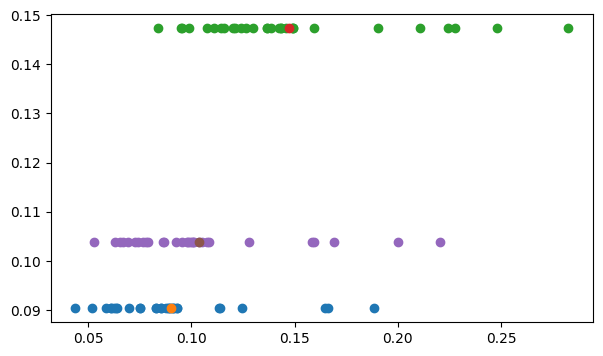

In [96]:
plt.figure(figsize=(7, 4))
i=0
plt.scatter(mse_per_image[:, i], [_metrics_75[0, i] for _ in range(mse_per_image.shape[0])]);
plt.scatter(_metrics_75[0, i], _metrics_75[0, i]);

i += 1
plt.scatter(mse_per_image[:, i], [_metrics_75[0, i] for _ in range(mse_per_image.shape[0])]);
plt.scatter(_metrics_75[0, i], _metrics_75[0, i]);

i += 1
plt.scatter(mse_per_image[:, i], [_metrics_75[0, i] for _ in range(mse_per_image.shape[0])]);
plt.scatter(_metrics_75[0, i], _metrics_75[0, i]);

In [141]:
all_metrics

array([[[ 0.16331411,  0.35055841,  0.1989003 ],
        [25.66595314, 21.17796882, 23.34905564],
        [ 0.77960324,  0.48864792,  0.72160084]],

       [[ 0.15520682,  0.2998152 ,  0.16142438],
        [24.51889362, 21.71553691, 22.70500281],
        [ 0.74511423,  0.52071691,  0.69997022]],

       [[ 0.12319334,  0.25156959,  0.13101369],
        [24.49656363, 22.32780164, 23.59628332],
        [ 0.74891612,  0.55551488,  0.70458955]],

       [[ 0.09678724,  0.20881366,  0.10875709],
        [25.37485436, 23.53322189, 24.25937498],
        [ 0.77444728,  0.60289503,  0.72300355]],

       [[ 0.08983512,  0.18822242,  0.10362438],
        [25.48413767, 23.32938579, 24.47602688],
        [ 0.78647258,  0.61673951,  0.73695819]],

       [[ 0.09150769,  0.18421502,  0.10775669],
        [25.3982894 , 23.36211702, 24.31130887],
        [ 0.7866588 ,  0.62277715,  0.73589816]]])

In [150]:
x = np.zeros(768) + np.ones(768) * np.random.randn(5, 10, 768)
x.shape

(5, 10, 768)

In [16]:
_metrics_75

array([[ 0.08897601,  0.16853954,  0.10320664],
       [25.87487592, 24.48287849, 24.35286014],
       [ 0.79036875,  0.65448524,  0.73708032]])

In [131]:
_metrics

array([[ 0.16331411,  0.35434631,  0.1989003 ],
       [25.66595582, 21.59718678, 23.34905688],
       [ 0.77960325,  0.48711835,  0.72160085]])

In [59]:
reconstracted_imgs_var[0].shape

torch.Size([224, 224, 3])

In [60]:
joint_var = torch.zeros((896, 1792, 3))
joint_gt = torch.zeros((896, 1792, 3))
joint_zeros = torch.zeros((896, 1792, 3))
img_gt = torch.zeros((896, 1792, 3))

k = 0
for i in range(4):
    for j in range(8):
        
        joint_var[i*224:(i+1)*224, j*224:(j+1)*224, :] = reconstracted_imgs_var[k]
        joint_zeros[i*224:(i+1)*224, j*224:(j+1)*224, :] = reconstracted_imgs_zeros[k]
        joint_gt[i*224:(i+1)*224, j*224:(j+1)*224, :] = reconstracted_imgs_gt[k]
        img_gt[i*224:(i+1)*224, j*224:(j+1)*224, :] = images[k]
        
        k+=1
        


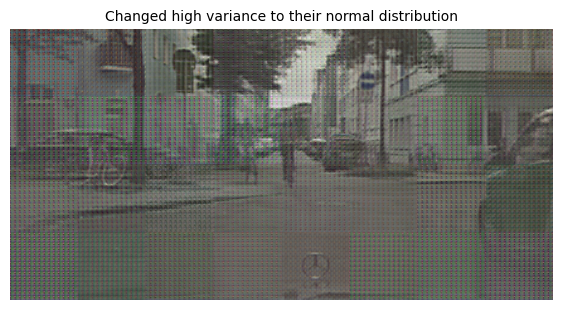

In [61]:
show_image(joint_var, title='Changed high variance to their normal distribution')

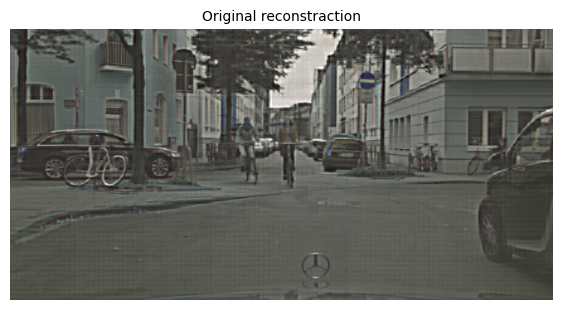

In [62]:
show_image(joint_gt, title='Original reconstraction')

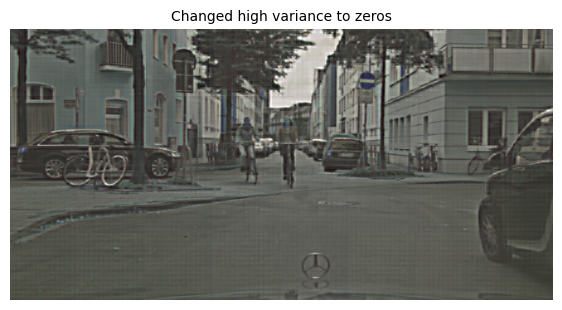

In [63]:
show_image(joint_gt, title='Changed high variance to zeros')

In [64]:
joint_var = joint_var.detach().numpy()
joint_gt = joint_gt.detach().numpy()
joint_zeros = joint_zeros.detach().numpy()
img_gt = img_gt.detach().numpy()

In [65]:
print("btw means and orig reconstr", metrics.mean_squared_error(joint_var, joint_gt))
print("btw zeros and orig reconstr", metrics.mean_squared_error(joint_zeros, joint_gt))
print("btw means and orig img", metrics.mean_squared_error(joint_var, img_gt))
print("btw zeros and orig img", metrics.mean_squared_error(joint_zeros, img_gt))
print("btw orig reconstr and orig img", metrics.mean_squared_error(joint_gt, img_gt))

btw means and orig reconstr 0.11995737472119289
btw zeros and orig reconstr 0.0176295188269796
btw means and orig img 0.3247572813443819
btw zeros and orig img 0.17251237171226122
btw orig reconstr and orig img 0.14149248754260704


In [66]:
# print("btw means and orig reconstr", metrics.peak_signal_noise_ratio(joint_var, joint_gt))
# print("btw zeros and orig reconstr", metrics.peak_signal_noise_ratio(joint_zeros, joint_gt))
print("btw means and orig img", metrics.peak_signal_noise_ratio(img_gt, joint_var))
print("btw zeros and orig img", metrics.peak_signal_noise_ratio(img_gt, joint_zeros))
print("btw orig reconstr and orig img", metrics.peak_signal_noise_ratio(img_gt, joint_gt))


ValueError: image_true has intensity values outside the range expected for its data type. Please manually specify the data_range.

In [68]:
img_gt.max(), img_gt.min(), joint_var.max(), joint_var.min()

(2.64, -2.117904, 2.8795493, -2.707187)

In [73]:
img_gt.max(), img_gt.min(), joint_zeros.max(), joint_zeros.min()

(2.64, -2.117904, 3.1484628, -2.3095427)

In [74]:
3.1484628 + 2.3095427

5.4580055000000005

In [75]:
2.8795493 + 2.117904

4.9974533

In [137]:
data_range = img_gt.max() - img_gt.min()
metrics.peak_signal_noise_ratio(img_gt, img_gt, data_range=10)
# metrics.peak_signal_noise_ratio(img_gt/255., joint_zeros/255.) #, data_range=5)

inf

In [98]:
x1 = img_gt[:, :, 2] / 255.
x2 = joint_var[:, :, 2] / 255.
res = np.zeros(3)
for i in range(3):
    data_range = joint_var[:, :, i].max() - joint_var[:, :, i].min()
    res[i] = metrics.structural_similarity(img_gt[:, :, i], joint_var[:, :, i], data_range=data_range) 
    
res.mean()
# metrics.structural_similarity(img_gt/255., joint_zeros/255., channel_axis=0)

0.31345613040560066

In [104]:
data_range = joint_var.max() - joint_var.min()
metrics.structural_similarity(img_gt, joint_var, channel_axis=2, data_range=data_range) 

0.32853803

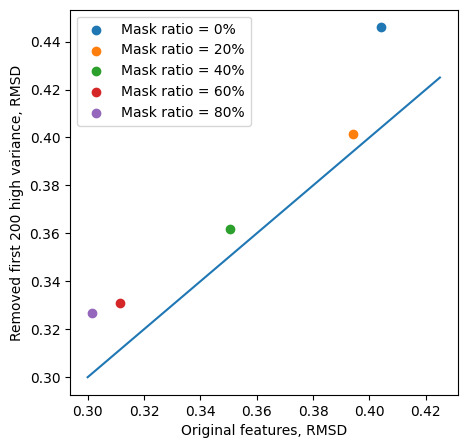

In [29]:
plt.figure()
for i in range(len(mask_ratios)):
    plt.scatter(losses[i][0].sqrt(), losses[i][1].sqrt(), label=f'Mask ratio = {mask_ratios[i]}%')
plt.plot([0.3, 0.425], [0.3, 0.425]);
plt.xlabel('Original features, RMSD')
plt.ylabel('Removed first 200 high variance, RMSD')
plt.legend();

In [76]:
losses.shape

torch.Size([5, 2])

In [54]:
images.shape

torch.Size([32, 224, 224, 3])

In [47]:
reconstracted_imgs_var_02.shape

torch.Size([32, 224, 224, 3])

In [69]:
loss = nn.MSELoss()
mse_loss_1 = loss(reconstracted_imgs_gt_02, images).item()
mse_loss_2 = loss(reconstracted_imgs_var_02, images).item()

In [71]:
mse_loss_1, mse_loss_2

(0.15484211578681278, 0.1610255530696132)

In [161]:
model='dinov2'
indices = np.load('/home/hkhachatrian/mae/varianceAnalysis/mae_sorted_features.npy')
embeds = np.load(f'/home/hkhachatrian/mae/embeddings/cs_patches_256/layers/{model}_cs4pc_256_train_12_embeds.npy')

In [162]:
embeds_val = np.load(f'/home/hkhachatrian/mae/embeddings/cs_patches_256/layers/{model}_cs4pc_256_val_12_embeds.npy')

In [163]:
tmp = (embeds - embeds.mean(axis=0)) / np.sqrt(embeds.var(axis=0))

In [164]:
tmp_val = (embeds_val - embeds.mean(axis=0)) / np.sqrt(embeds.var(axis=0))

In [139]:
embeds.var(axis=0).shape

(768,)

In [138]:
embeds

array([[-0.28549045,  0.09062131, -0.55018836, ..., -0.18592961,
        -0.31210026,  0.24417621],
       [-0.03894736, -0.12151392,  1.366337  , ..., -0.18288599,
         0.3569665 , -0.2678205 ],
       [ 0.00796799, -0.05136459,  1.6117474 , ..., -0.04121714,
         0.4919881 , -0.09031282],
       ...,
       [ 0.14191823, -0.03708127, -0.6774666 , ..., -0.19273973,
         0.08486475,  0.04132416],
       [ 0.3671656 ,  0.17010476, -0.6283569 , ..., -0.16705501,
         0.04136801, -0.0101176 ],
       [ 0.48228776,  0.02926681,  0.35799327, ..., -0.17723145,
         0.34257048, -0.05081191]], dtype=float32)

In [129]:
tmp.shape

(451584, 768)

In [165]:
np.save(f'../embeddings/cs_patches_256/norm_{model}_cs4pc_256_train_embeds.npy', tmp)

In [166]:
np.save(f'../embeddings/cs_patches_256/norm_{model}_cs4pc_256_val_embeds.npy', tmp_val)

In [145]:
tmp_val.var(axis=0)

array([1.03462   , 0.9731124 , 1.0025015 , 1.0062748 , 1.0371519 ,
       1.0210176 , 1.0193081 , 0.9965702 , 1.0004405 , 1.0353184 ,
       0.96299875, 0.9791687 , 1.0101807 , 1.0029361 , 1.017885  ,
       1.0000976 , 0.98036236, 1.0593548 , 0.9982502 , 1.0115801 ,
       1.0317464 , 1.0819811 , 1.032086  , 1.05247   , 1.0389247 ,
       1.018732  , 1.043697  , 1.0234798 , 0.96762174, 0.9867931 ,
       0.9517049 , 0.9942515 , 0.9513089 , 1.0231469 , 1.0157278 ,
       1.00505   , 1.0096287 , 1.0046318 , 0.9740436 , 1.010514  ,
       1.0216278 , 0.9912663 , 1.0074944 , 1.0298431 , 0.94224447,
       1.007104  , 1.0127585 , 1.0443532 , 1.009012  , 1.0254552 ,
       1.0170728 , 1.04161   , 0.9984826 , 0.98062265, 1.0354897 ,
       1.0078723 , 1.0130852 , 0.99374884, 1.0013808 , 1.0645502 ,
       1.0115619 , 1.0451856 , 1.003134  , 1.025812  , 0.9721668 ,
       1.000085  , 1.0007336 , 1.0279831 , 1.0200783 , 0.9850946 ,
       1.0088221 , 1.0117892 , 1.0014287 , 1.0293745 , 0.99389

In [137]:
tmp[0][::-1]

array([ 1.44828188e+00,  1.39412856e+00,  1.38124168e+00,  1.32176793e+00,
        1.30636466e+00,  1.26301646e+00,  1.24584651e+00,  1.18566585e+00,
        1.17539883e+00,  1.17169082e+00,  1.13521731e+00,  1.10506523e+00,
        1.08597708e+00,  1.06809151e+00,  1.05889142e+00,  1.05484855e+00,
        1.05092728e+00,  1.04174566e+00,  1.03395772e+00,  1.02209544e+00,
        1.01936412e+00,  1.01727247e+00,  1.01219881e+00,  1.00617743e+00,
        1.00173211e+00,  9.89792585e-01,  9.75884616e-01,  9.72604752e-01,
        9.66901183e-01,  9.59793925e-01,  9.52787399e-01,  9.46969509e-01,
        9.29216564e-01,  9.27808225e-01,  9.19587791e-01,  9.16577697e-01,
        8.96591306e-01,  8.95979047e-01,  8.90921235e-01,  8.69596601e-01,
        8.68225694e-01,  8.66981745e-01,  8.63267958e-01,  8.36654127e-01,
        8.35028589e-01,  8.32463145e-01,  8.27589571e-01,  8.26076031e-01,
        8.25441122e-01,  8.17415297e-01,  8.16733956e-01,  8.00114095e-01,
        7.96861887e-01,  

In [16]:
embeds.shape, indices.shape

((451584, 768), (768,))

In [42]:
indices[:10]

array([614, 158, 508, 420, 147, 113, 539, 599,  18, 288])

In [48]:
embeds.var(axis=0)[indices[:10]]

array([42.22259  , 13.720981 ,  8.393904 ,  6.150236 ,  5.069063 ,
        4.877397 ,  3.9615078,  3.4632719,  2.9972904,  1.6982113],
      dtype=float32)

In [11]:
mean_var = np.concatenate([embeds.mean(axis=0).reshape(768, 1),
                           embeds.var(axis=0).reshape(768, 1)], axis=1)
# embeds.var(axis=0).shape, embeds.mean(axis=0).shape
mean_var.shape

(768, 2)

In [13]:
mean_var[indices[0:200], 0][:10]

array([ 4.8419371e+00, -8.3471727e+00, -3.6020648e-01, -1.9932454e+00,
        2.4860568e-02,  1.6921295e-03,  3.0060878e+00, -4.4961613e-02,
       -2.0054577e-01, -9.6209340e-02], dtype=float32)

In [27]:
x = embeds_1[:, 1:, indices[:]]

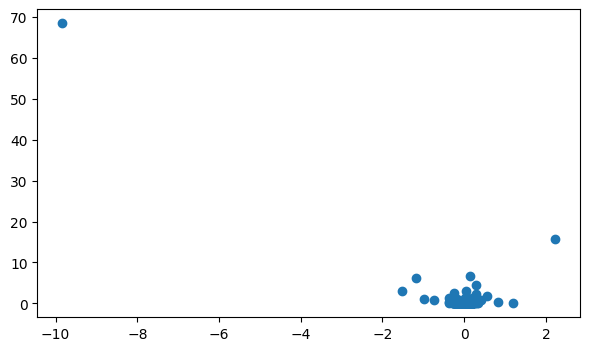

In [28]:
plt.figure(figsize=(7, 4))
plt.scatter(x.mean(axis=1), x.var(axis=1));

In [35]:
# plt.figure(figsize=(7, 4))
print(np.argmax(x.var(axis=-1), axis=-1))

tensor([28])


In [118]:
embeds.mean(axis=0)[0], embeds.var(axis=0)[0]

(0.37898535, 0.40998113)

In [120]:
embeds.mean(axis=0)[indices[:10]]

array([ 4.8419371e+00, -8.3471727e+00, -3.6020648e-01, -1.9932454e+00,
        2.4860568e-02,  1.6921295e-03,  3.0060878e+00, -4.4961613e-02,
       -2.0054577e-01, -9.6209340e-02], dtype=float32)

In [119]:
mean_var[indices[:10], 0], mean_var[indices[:10], 1]

(array([ 4.8419371e+00, -8.3471727e+00, -3.6020648e-01, -1.9932454e+00,
         2.4860568e-02,  1.6921295e-03,  3.0060878e+00, -4.4961613e-02,
        -2.0054577e-01, -9.6209340e-02], dtype=float32),
 array([42.22259  , 13.720981 ,  8.393904 ,  6.150236 ,  5.069063 ,
         4.877397 ,  3.9615078,  3.4632719,  2.9972904,  1.6982113],
       dtype=float32))

In [99]:
mean_var[indices[0]]

array([ 4.841937, 42.22259 ], dtype=float32)

In [107]:
np.sqrt(variances).shape

(768,)

In [21]:
np.random.seed(0)
vals = np.array([mean_var[:, 0] + np.sqrt(mean_var[:, 1]) * np.random.randn(768) for _ in range(1000)])

In [22]:
vals.shape

(1000, 768)

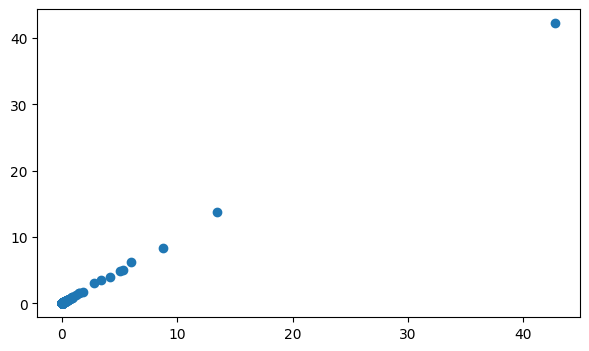

In [23]:
plt.figure(figsize=(7, 4))
plt.scatter(vals.var(axis=0), mean_var[:, 1]);

In [100]:
np.random.seed(0)
mean, var = mean_var[indices[0]]

np.random.normal(loc=mean, scale=var)

79.32479847738703

In [104]:
np.random.seed(0)
np.random.normal(*mean_var[indices[0]])

79.32479847738703

In [ ]:
np.random.normal()

In [26]:
embeds = embeds.reshape(72, -1, 768)

In [21]:
embeds[:, :, indices[:200]] = 0

In [37]:
if 28 in indices[:200]:
    print('yes')

### Load another pre-trained MAE model

In [ ]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')to

### Run MAE on the image

MAE with extra GAN loss:


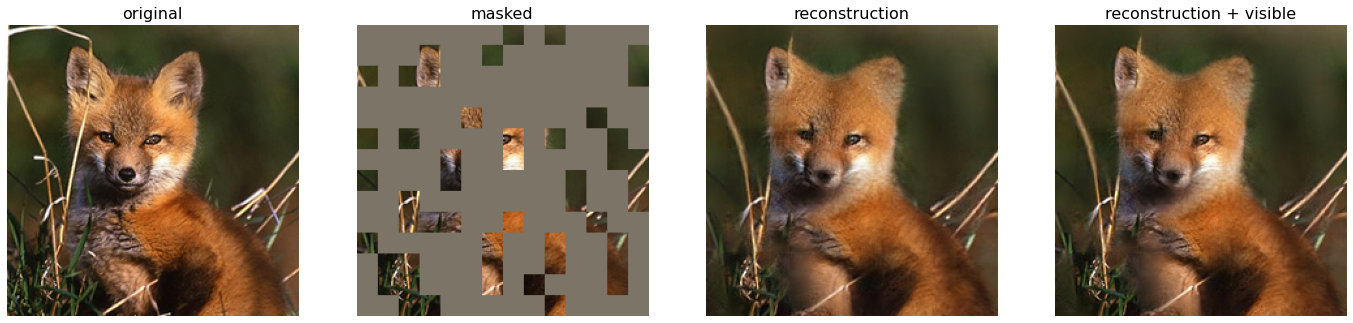

In [7]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)